# Implementing a unitary quantum perceptron with quantum computing

Following the work  (<a href="https://iopscience.iop.org/article/10.1209/0295-5075/125/30004" title="link">1</a>), the perceptron can be implemented as a single (fast) adiabatic passage in a model of interacting spins. The adiabatic procedure has already been demonastrated in highly connected architectures with superconducting qubits (<a href="https://www.nature.com/articles/nphys2385" title="link">2</a>) and trapped ions (<a href="https://arxiv.org/abs/2111.08977" title="link">3</a>).

Here, we simulate the aforementioned physical system with quantum computing.   

## But first things first, what is a perceptron?

A perceptron maps a set of m inputs $ \{ x^{\mu}_i \}$ to an output $\sigma^{\mu}$ according to the rule that

\begin{align}
\sigma^{\mu}=\left\{\begin{array}{ll}
1 & \text { if } \mathbf{w} \cdot \mathbf{x}+ \mathbf{ b } >0 \\
-1 & \text { otherwise }
\end{array}\right.
\end{align}

where  $\mathbf{w}$ is a vector of real-valued weights and $\mathbf{ b }$ is the bias. 

A simple perceptron model with two inputs and one output:

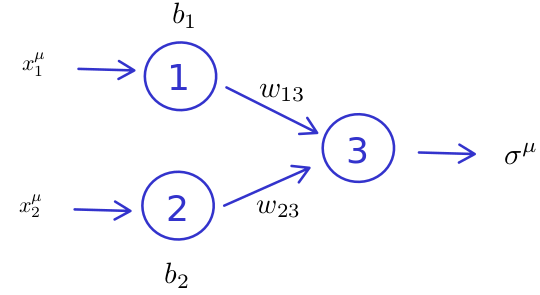

## And now, what is a quantum perceptron?

One way of realizing a quantum perceptron is by keeping the same schematic picture, but implementing it on actual quantum hardware. So, basically we move from semiconductor devices to superconducting and trapped ions.

## How can we implement the unitary quantum perceptron with quantum computing?

The quantum perceptron is basically a qubit with a nonlinear excitation respone to the input field. Therefore, the perceptron gate can be implemented as a single (fast) adiabatic passage in a model of interacting spins (<a href="https://iopscience.iop.org/article/10.1209/0295-5075/125/30004" title="link">1</a>).

The perceptron gate is constructed by evolving a qubit with the Ising Hamiltonian : 

\begin{align}
\hat{H}(t) = \left[-\Omega(t)\hat{\sigma}^x_j+b_j\hat{\sigma}_j^z- \sum_{k<j} \big(\omega_{jk}\hat\sigma_k^z\hat\sigma_j^z\big)\right],
\end{align}

where $ \Omega(t) $ is the external transverse field.

The effect of the input field is to generate a SU(2) rotation of a qubit parametrized by
\begin{align}
 \hat U_j(\hat{x}_j;f) = \exp\left\{i \arcsin[f(\hat{x}_j)^{1/2}] \hat\sigma^y_j\right\}\mbox{ with},
 \hat{x}_j  =\sum_{k<j} w_{jk} \hat\sigma^{z}_k - b_j.\nonumber
 \end{align}

This operator can also be written as
\begin{align}
\hat U(\hat x;f)=\mathbb{I}\otimes cos\left[\frac{\pi}{2}f(\sum_{i=1}^{N}w_i\hat\sigma_i^z-b_i)\right]+\nonumber
+i\hat\sigma_{N+1}^y\otimes sen\left[\frac{\pi}{2}f(\sum_{i=1}^{N}w_i\hat\sigma_i^z-b_i)\right],
\end{align}

where a single perceptron j = N + 1 is connected to N input neurons.

For the simple perceptron presented above, the unitary operator has a shape 8x8, since we have 3 qubits in total: two for the inputs and one for the output. We define the unitary operator in the function UnitaryOperator.

## "The way to get started is to quit talking and begin doing" - Walt Disney. In our case, begin coding!

In [1]:
import pennylane as qml
from pennylane import numpy as np
from math import pi

import matplotlib.pyplot as plt

In [2]:
# The unitary operator
def UnitaryOperator(params):
    #The parameters of the operator for two inputs and one output.
    w1, b1 = params[0]
    w2, b2 = params[1]
    
    #The explicit representation of unitary following eq.
    U=[[np.cos((1/2)*pi*act(w1 - b1 + w2 - b2)), 0, 0, 0, -np.sin(act(w1 - b1 + w2 - b2)*(1/2)*pi), 0, 0, 0], [0, np.cos((1/2)*pi*act(w1 - b1 - w2 - b2)), 0, 0, 0, -np.sin((1/2)*pi*act(w1 - b1 - w2 - b2)), 0, 0], [0, 0, np.cos((1/2)*np.pi*act(-w1 - b1 + w2 - b2)), 0, 0, 0, -np.sin((1/2)*pi*act(-w1 - b1 + w2 - b2)), 0], [0, 0, 0, np.cos(1/2*pi*act(-w1 - b1 - w2 - b2)), 0, 0, 0, -np.sin(1/2*pi*act(-w1 - b1 - w2 - b2))], [np.sin(1/2*pi*act(w1 - b1 + w2 - b2)), 0, 0, 0, np.cos(1/2*pi*act(w1 - b1 + w2 - b2)), 0, 0, 0], [0, np.sin(1/2*pi*act(w1 - b1 - w2 - b2)), 0, 0, 0, np.cos(1/2*pi*act(w1 - b1 - w2 - b2)), 0, 0], [0, 0, np.sin(1/2*pi*act(-w1 - b1 + w2 - b2)), 0, 0, 0, np.cos(1/2*pi*act(-w1 - b1 + w2 - b2)), 0], [0, 0, 0,np.sin(1/2*pi*act(-w1 - b1 - w2 - b2)), 0, 0, 0, np.cos(1/2*pi*act(-w1 - b1 - w2 - b2))]]
    Uarray = np.array(U)
    
    return Uarray

The activation function is the excitation probability (see eq.2 in <a href="https://iopscience.iop.org/article/10.1209/0295-5075/125/30004" title="link">1</a>).

In [3]:
def act(x):
    return ((1 + x/np.sqrt(1 + x**2))/2)

Now, we simulate the aforementioned physical system with quantum computing.  First, we need to define the quantum circuit.

In [4]:
#The quantum circuit of the perceptron.

dev = qml.device('default.qubit', wires=3)
@qml.qnode(dev)

def qcircuit_perceptron(U, x):
    # We need to encode the inputs on the quantum circuit.
    for i in range(len(x)):
        if x[i] == 1:
            qml.PauliX(i)
            
    # Then, we can apply the unitary operator defined in the above function.
    qml.QubitUnitary(U, wires=[0,1,2])

    return qml.expval(qml.PauliZ(0))

To demonstrate the learning ability of the quantum perceptron we train it to perform the XOR gate. 

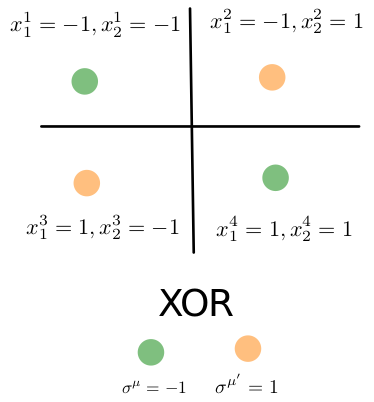

Contrary to its classical version, the quantum perceptron can realize this non-linear classification problem. Here, we optimize the values of $\mathbf{w}$ and $\mathbf{ b }$ of the quantum perceptron to perform the XOR gate.

In [5]:
# Define the training set
x_train = np.array([[-1,-1],[1.,-1],[-1,1.],[1.,1.]]*20)
y_train = np.array([-1,1,1,-1]*20)

In [6]:
# Define the cost function
def cost(params, x=None, y=None):
    Uop = UnitaryOperator(params)
    loss = 0.0
    for i in range(len(x)):
        fidelity = qcircuit_perceptron(Uop, x=x[i])
        loss = loss + (y[i] - fidelity)**2 
    return loss/len(x)

In [7]:
# Initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# Set the number of steps
steps = 100
# Set a random seed
np.random.seed(42)
# Set the initial parameter values
params = np.random.uniform(size=(2, 2))
U = UnitaryOperator(params)
measure = qcircuit_perceptron(U, np.array([1,1]))

loss_list = []

for i in range(steps):
    # update the circuit parameters
    loss_list.append(cost(params, x_train, y_train))
    params = opt.step(lambda v: cost(v, x_train, y_train), params)

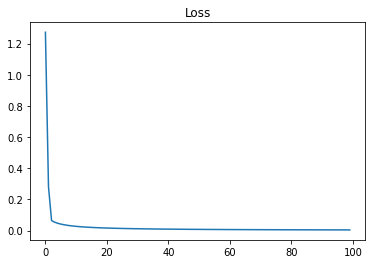

In [8]:
plt.plot(loss_list)
plt.title("Loss")
plt.show()
plt.close()

In [9]:
# final value of the parameters w and theta for the XOR problem
params

tensor([[1.20113392, 0.67825643],
        [1.00445182, 0.3262006 ]], requires_grad=True)

In [10]:
#Final matrix of the Unitary operator
Uop = UnitaryOperator(params)
print (Uop)

[[ 0.18080628  0.          0.          0.         -0.98351873  0.
   0.          0.        ]
 [ 0.          0.95770666  0.          0.          0.         -0.28774633
   0.          0.        ]
 [ 0.          0.          0.98351911  0.          0.          0.
  -0.18080418  0.        ]
 [ 0.          0.          0.          0.99936842  0.          0.
   0.         -0.03553544]
 [ 0.98351873  0.          0.          0.          0.18080628  0.
   0.          0.        ]
 [ 0.          0.28774633  0.          0.          0.          0.95770666
   0.          0.        ]
 [ 0.          0.          0.18080418  0.          0.          0.
   0.98351911  0.        ]
 [ 0.          0.          0.          0.03553544  0.          0.
   0.          0.99936842]]


In [11]:
# check the correct operation of the XOR with the quantum perceptron for some inputs
for i in range (0, 4):
    print (x_train[i], y_train[i])
    print (qcircuit_perceptron(Uop, x_train[i]))

[-1. -1.] -1
-0.9346181748114648
[ 1. -1.] 1
0.9346181748114648
[-1.  1.] 1
0.9346196980886778
[1. 1.] -1
-0.9346196980886778


Finally, we have to check that the final Unitary Operator is indeed a unitary matrix. 

In [12]:
# Function that returns True if the final unitary operator is indeed unitary. 
def unitary_check(operator):
    Ucon = np.conjugate(operator)
    Uher = np.transpose(Ucon) 
    
    DotProd = np.dot(operator, Uher)
    IdentityOperator = np.identity(operator.shape[0])
    
    return (np.allclose(DotProd, IdentityOperator, rtol=1e-10, atol=1e-10))

unitary_check(Uop)

True

## So, the quantum perceptron can realize the XOR gate contrary to its classical counterpart (<a href="https://oxford.universitypressscholarship.com/view/10.1093/acprof:oso/9780198509417.001.0001/acprof-9780198509417" title="link">4</a>).

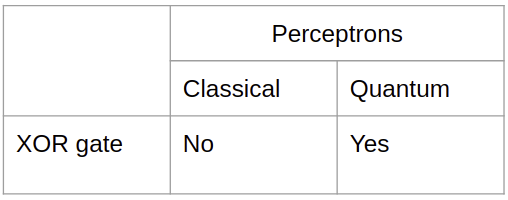

## What more have quantum perceptrons to offer?

Inspired by the the energetic efficiency of Google’s Sycamore quantum processor over the supercomputer executing the same algorithm (<a href="https://www.nature.com/articles/s41586-019-1666-5#Abs1" title="link">5</a>), we explore the power consumption of a quantum perceptron. 

Both for classical and quantum perceptrons, the power needed for the perceptron itself is insignificant compared to the power consumption to keep the system in order. For example, the energetic cost of the driving in the quantum perceptron is only a few pW for superconducting qubits (<a href="https://arxiv.org/abs/2111.09241" title="link">6</a>), which is negligible to its true power consumption. 

The main power consumption in the classical perceptron comes from various heat currents and is approximately 10mW (<a href="https://www.nature.com/articles/s41565-021-00874-8" title="link">7</a>). For the quantum perceptron, the main power consumption comes from cooling the system in low temperatures: 0.01-0.02 K for superconducting, 4.0-5.0 K for ion trap and 0.1-10 K silicon quantum devices (<a href="https://arxiv.org/abs/2103.16726" title="link">8</a>). For the worst case of superconducting perceptrons, the power consumption is approximately 1mW (<a href="https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040335" title="link">9</a>). 

So, the quantum perceptron is already energetically more efficient.

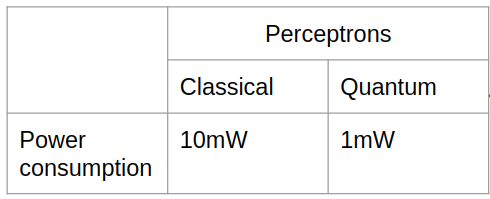

It will be quite interesting to see how this gap on the power consumption will increase in the years to come!

#### Acknowledgements
I would like to thank Erik  Torrontequi and Patrick Huembeli for insights on the theoretical foundations and on the code, respectively. I would also like to thank Friederike Metz for interesting discussions and Francesco Tacchino for pointing out relevanant literature on the power consumption.